# Defect Prediction

We will attempt to predict defects using the PC1 dataset used in this week's paper "Data Mining Static Code Attributes to Learn Defect Predictors."

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Use fixed random seed, so that notebook always produces the same results
# We will use the random_state argument to set the seed in appropriate function calls
myseed = 1

## Exploratory Data Analysis

The first two steps of building a model: 1) Data Collection and 2) Feature Extraction have already been completed for you. 

In this section, we load a CSV file contained the samples with features and labels as a Pandas data frame, then examine the contents of the data.

In [3]:
df = pd.read_csv('pc1.csv')

In [4]:
# How many rows (samples) and columns (features + label) are in the data?
df.shape

(1109, 22)

In [5]:
# Find data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 22 columns):
loc                  1109 non-null float64
v(g)                 1109 non-null float64
ev(g)                1109 non-null float64
iv(G)                1109 non-null float64
N                    1109 non-null float64
V                    1109 non-null float64
L                    1109 non-null float64
D                    1109 non-null float64
I                    1109 non-null float64
E                    1109 non-null float64
B                    1109 non-null float64
T                    1109 non-null float64
lOCode               1109 non-null int64
lOComment            1109 non-null int64
locCodeAndComment    1109 non-null int64
lOBlank              1109 non-null int64
uniq_Op              1109 non-null float64
uniq_Opnd            1109 non-null float64
total_Op             1109 non-null float64
total_Opnd           1109 non-null float64
branchCount          1109 non-null float6

In [6]:
# Convert defects to binary 0/1 data from boolean
df.defects = df.defects.astype(int)

In [7]:
# Examine a random sample of the data
df.sample(10)

,loc,v(g),ev(g),iv(G),N,V,L,D,I,E,...,lOCode,lOComment,locCodeAndComment,lOBlank,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
646,62.0,18.0,12.0,11.0,319.0,1974.55,0.03,39.28,50.27,77553.76,...,62,1,0,6,26.0,47.0,177.0,142.0,35.0,0
807,6.0,1.0,1.0,1.0,15.0,51.89,0.34,2.92,17.79,151.35,...,6,0,0,1,5.0,6.0,8.0,7.0,1.0,0
264,8.0,4.0,1.0,4.0,28.0,106.61,0.22,4.50,23.69,479.73,...,5,5,3,6,6.0,8.0,16.0,12.0,7.0,0
411,31.0,7.0,5.0,4.0,125.0,660.68,0.03,32.08,20.59,21196.67,...,28,19,3,14,21.0,18.0,70.0,55.0,13.0,0
335,21.0,9.0,4.0,7.0,94.0,470.00,0.04,23.80,19.75,11186.00,...,18,0,3,2,17.0,15.0,52.0,42.0,15.0,0
918,5.0,1.0,1.0,1.0,21.0,77.71,0.23,4.29,18.13,333.04,...,5,0,0,0,6.0,7.0,11.0,10.0,1.0,0
341,40.0,9.0,1.0,5.0,247.0,1492.97,0.03,33.54,44.52,50068.96,...,40,3,0,16,25.0,41.0,137.0,110.0,17.0,0
195,15.0,1.0,1.0,1.0,48.0,210.83,0.12,8.18,25.77,1724.98,...,15,12,0,14,10.0,11.0,30.0,18.0,1.0,0
852,11.0,1.0,1.0,1.0,84.0,430.86,0.09,11.23,38.38,4837.38,...,11,0,0,2,13.0,22.0,46.0,38.0,1.0,0
174,16.0,1.0,1.0,1.0,54.0,244.27,0.12,8.08,30.24,1972.97,...,16,12,0,11,10.0,13.0,33.0,21.0,1.0,0


## EDA Visualization

Let's visualize the data to see how each variable is distributed. Since this is a binary prediction dataset, the response variable Forgery has only two values, 0 and 1. Our visualizations will start with histograms, then use boxplots and kernel density plots.

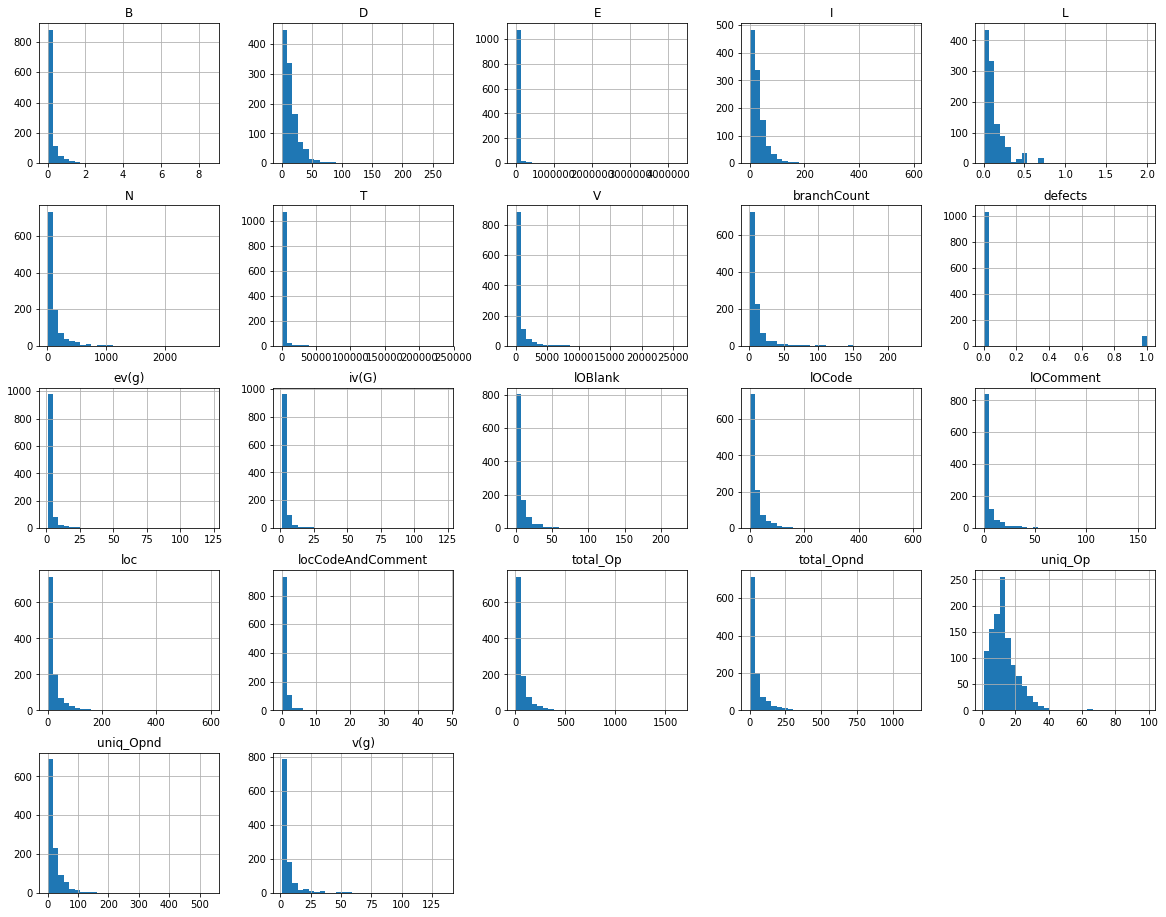

In [18]:
df.hist(bins=30, figsize=(20,16));

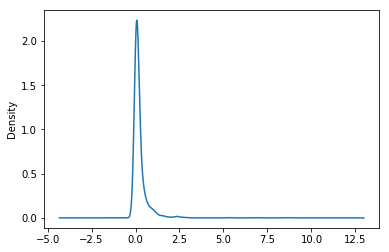

In [19]:
df["B"].plot.kde();

## Prepare Data for Machine Learning

The pandas data frame contains both the 4 features and label for each sample. We need to separate the features and the label for scikit-learn and convert them from data frames to NumPy arrays that scikit-learn expects. We create a vector (one-dimensional array) of labels and an array of features.

In [10]:
# Create vector of response variable (label) and matrix of features
y = df['defects'].values                  # y is response vector
X = df.drop('defects', axis=1).values     # X is array of predictors(features)

In [11]:
# Check shape of y to verify it's a vector with the same number of samples as the data frame
y.shape

(1109,)

In [12]:
# Check shape of X to verify it's an array with 4 columns for features and same number of rows as y
X.shape

(1109, 21)

In [13]:
# Log transform predictors as in paper
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

In [14]:
X = transformer.transform(X)

We split the data in training and test sets, with 80% of the data used for training and 20% for testing. We set the random_state parameter so that the split will be the same each time.

In [15]:
# Split dataset up into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [16]:
# Check size of training and test sets; it appears the split rounds up.
# Note: you must use print() to get multiple outputs from a Jupyter notebook cell
print(round(0.2 * X.shape[0]),1)
print(X_train.shape)
print(X_test.shape)

222 1
(887, 21)
(222, 21)


In [21]:
X

array([[0.74193734, 0.87546874, 0.87546874, ..., 0.78845736, 0.78845736,
        0.87546874],
       [0.69314718, 0.69314718, 0.69314718, ..., 0.69314718, 0.69314718,
        0.69314718],
       [4.52178858, 2.30258509, 1.38629436, ..., 5.26269019, 4.84418709,
        2.89037176],
       ...,
       [1.79175947, 1.38629436, 1.38629436, ..., 2.48490665, 1.94591015,
        1.79175947],
       [2.94443898, 2.19722458, 1.79175947, ..., 4.12713439, 3.93182563,
        2.77258872],
       [3.29583687, 2.94443898, 2.63905733, ..., 4.78749174, 4.70048037,
        3.58351894]])

In [24]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [25]:
y_pred1 = gnb.predict(X_test)

In [26]:
# Compare test set predictions with ground truth labels
round(accuracy_score(y_pred1, y_test), 3)

0.748

In [27]:
# The confusion matrix shows correct classifications on the upper left to lower right diagonal.
cm1 = confusion_matrix(y_test, y_pred1)
cm1

array([[162,  45],
       [ 11,   4]])

In [28]:
# We can extract the number of True Positives, False Positives, True Negatives, and False Negatives
tn1, fp1, fn1, tp1 = cm1.ravel()
(tn1, fp1, fn1, tp1)

(162, 45, 11, 4)

In [29]:
accuracy1 = (tn1 + tp1)/(tn1 + tp1 + fn1 + fp1)
round(accuracy1, 3)

0.748

In [30]:
# Precision is the ratio of positives correctly predicted to the total number of actual positives. 
# It is the most important metric when we want to minimize false positives.
precision1 = tp1 / (tp1 + fp1)
round(precision1, 3)

0.082

In [31]:
# Recall is the percent of actual positive values predicted. 
# It is most important metric when we want to minimize false negatives.
recall1 = tp1 / (tp1 + fn1)
round(recall1, 3)

0.267

In [32]:
# F1 combines precision and recall to take both types of errors evenly into account.
f11 = 2 * (precision1 * recall1) / (precision1 + recall1)
round(f11, 3)

0.125